
<a name="top"></a>
# <div style="text-align: center"> <u>Data Science Capstone Project </u> </div>
# <div style="text-align: center"><u>_The Battle of the Neighbourhoods - LA Edition_<u/></div>
### <div style="text-align: right"> - [Ishaan Vasant](https://www.linkedin.com/in/ishaan-vasant/) </div>
***


## <u>Table of contents</u>

<div class="alert alert-block alert-info" style="margin-top: 20px">

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## <u>Introduction: Business Problem</u><a name="introduction"></a>

<p style='text-align: justify;'> Los Angeles, often known by its initials LA, is the most populous city in California and the second most populous city in the United States. Los Angeles is the cultural, financial, and commercial center of Southern California. The city is known for its Mediterranean climate, ethnic diversity, Hollywood, the entertainment industry, and its sprawling metropolis. </p>

<p style='text-align: justify;'>Having lived in LA for over a year now, I can confirm that Los Angeles is also one of the most amazing places to eat, thanks to an incredible variety of international cuisines and some of the most talented chefs in the world. It is a multicultural city, with the biggest communities of several nationalities of people outside of their homelands. They bring their cuisines with them. LA’s thriving economy, great seasonal produce and access to ingredients makes it an ideal place for restaurants to flourish. </p>

<p style='text-align: justify;'>The objective of this project is to identify the best potential neighbourhoods where a restaurant can be set up. An [international YouGov study](https://yougov.co.uk/topics/food/articles-reports/2019/03/12/italian-cuisine-worlds-most-popular) of more than 25,000 people in 24 countries found that pizza and pasta are among the most popular foods in the world, as Italian cuisine beats all comers. According to their analysis, 88% of people surveyed in America liked Italian food. Keeping this in mind, the focus of this capstone would be Italian restaurants. Therefore, the analysis and results of this project would interest stakeholders who are interested in **opening an Italian restaurant in Los Angeles**. </p>

<p style='text-align: justify;'>Since there are lots of restaurants in LA, neighbourhoods that are **not already crowded with restaurants** would be shortlisted. The next filter would be neighbourhoods with the **least number of Italian restaurants in its vicinity**. Neighbourhoods that are **as close to city center as possible** would be preferred. Neighbourhood **rent** is another factor that would be taken into consideration.</p>

[Back to top of notebook](#top)

## <u>Data</u> <a name="data"></a>

Based on the criteria specified above, the factors that will influence the final decision are: -
* Number of existing restaurants in the neighbourhood (any type of restaurant) 
* Number of and distance to Italian restaurants in the neighbourhood
* Distance of neighbourhood from city center
* Average neighbourhood rent

The following data sources will be needed to extract/generate the required information: -
* List of all neighbourhoods in LA - https://en.wikipedia.org/wiki/List_of_districts_and_neighbourhoods_of_Los_Angeles
* Coordinates of all neighbourhoods and venues - **GeoPy Nominatim geocoding**
* Number of restaurants and their type and location in every neighbourhood - **Foursquare API** -  https://developer.foursquare.com
* LA rent data - https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/


[Back to top of notebook](#top)

## <u>Methodology</u><a name="methodology"></a>

<p style='text-align: justify;'>In this project the first step will be to collect data on the neighbourhoods of Los Angeles from the internet. There are no relevant datasets available for this and therefore, data will need to be scraped from a webpage. The location coordinates of each neighbourhood will then be obtained with the help of GeoPy Nominatim geolocator and appended to the neighbourhood data. Using this data, a folium map of the Los Angeles neighbourhoods will be created.</p>

<p style='text-align: justify;'>The second step will be to explore each of neighbourhoods and their venues using Foursquare location data. The venues of the neighbourhoods will be analyzed in detail and patterns will be discovered. This discovery of patterns will be carried out by grouping the neighbourhoods using k-means clustering. Following this, each cluster will be examined and a decision will be made regarding which cluster fits the shareholder's requirements. The factor that will determine this is the frequency of occurrence of restaurants and other food venues within the cluster.</p>

<p style='text-align: justify;'>Once a cluster is picked, the neighbourhoods in that cluster will be investigated with regards to the number of Italian restaurants in its vicinity. The ones that fit the requirements will be further explored and shortlisted based on how small their respective distances to the center or Los Angeles are. Finally, if there are multiple neighbourhoods that fit these conditions, Los Angeles rent data can be used to influence the shareholder's decision. </p>

<p style='text-align: justify;'>The results of the analysis will highlight potential neighbourhoods where an Italian restaurant may be opened based on geographical location and proximity to competitors. This will only serve as a starting point since there are a lot of other factors that influence such a decision. </p>

[Back to top of notebook](#top)

## <u>Analysis</u><a name="analysis"></a>

* [Importing Libraries](#import)
* [Web Scraping Neighbourhood Data ](#scrapenh)
* [Loading and Cleaning Neighbourhood ](#clean)
* [Obtaining Neighbourhood Coordinates  ](#coordinates)
* [ LA Neighbourhood Map ](#lamap)
* [Defining Foursquare Credentials and Version  ](#foursquare)
* [ Exploring the first Neighbourhood ](#first)
* [Exploring all Neighbourhoods  ](#all)
* [Analyzing each Neighbourhood  ](#analyze)
* [Clustering Neighbourhoods  ](#cluster)
* [Examining the Clusters  ](#examine)
* [Visualizing Top 10 Venues for each Cluster  ](#visualize)
* [Investigating the chosen Cluster  ](#investigate)
* [Web Scraping Rent Data  ](#rent)

### Importing Libraries <a name="import"></a>

The first step in the analysis is importing the required libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas data frame

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [396]:
import re

[Back to top of Analysis](#analysis)

### Web Scraping Neighbourhood Data <a name="scrapenh"></a>

The list of all neighbourhoods in LA is obtained by scraping the relevant webpage. The data in the webpage is in the form of a list and not a table. Therefore, the data is obtained by searching for all list items and then using a particular characteristic that groups the required items.

In [397]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighbourhoods_of_Los_Angeles').text
soup = BeautifulSoup(url,"html.parser")

In [398]:
lis = []
for li in soup.findAll('li'):
    if li.find(href="/wiki/Portal:Los_Angeles"):
        break
    if li.find(href=re.compile("^/wiki/")):
        lis.append(li)
    if li.text=='Pico Robertson[34]': #Pico Robertson is the only item on the list that does not have a hyperlink reference
        lis.append(li)


[Back to top of Analysis](#analysis)

### Loading and Cleaning Neighbourhood <a name="clean"></a>

In [722]:
neigh = []
for i in range(0,len(lis)):
    neigh.append(lis[i].text.strip())
    
df = pd.DataFrame(neigh)
df.columns = ['Neighbourhood']

In [723]:
df

,Neighbourhood
0,Angelino Heights[TG]
1,Arleta[MLA][TG]
2,Arlington Heights[MLA]
3,Arts District[1]
4,Atwater Village[MLA]
5,Baldwin Hills[TG]
6,Baldwin Hills/Crenshaw[MLA]
7,Baldwin Village[TG]
8,Baldwin Vista[2]
9,Beachwood Canyon[3]


In [724]:
df['Neighbourhood'] = df.Neighbourhood.str.partition('[')[0] #Removes the citation and reference brackets
df['Neighbourhood'] = df.Neighbourhood.str.partition(',')[0] #Removes the alternatives for 'Bel Air'
df=df[df.Neighbourhood!='Baldwin Hills/Crenshaw'] #Removes redundancy as 'Baldwin Hills' and 'Crenshaw' exist already
df=df[df.Neighbourhood!='Hollywood Hills West'] #Removes redundancy as it has the same coordinates as 'Hollywood Hills'
df=df[df.Neighbourhood!='Brentwood Circle'] #Removes redundancy as it has the same coordinates as 'Brentwood'
df=df[df.Neighbourhood!='Wilshire Park'] #Removes redundancy as it has the same coordinates as 'Wilshire Center'
df.reset_index(inplace=True,drop=True)

[Back to top of Analysis](#analysis)

### Obtaining Neighbourhood Coordinates  <a name="coordinates"></a>

In [725]:
# define the data frame columns
column_names = ['Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the data frame
nhoods = pd.DataFrame(columns=column_names)

Using GeoPy Nominatim geolocator with the user_agent "la_explorer".

In [726]:
geolocator = Nominatim(user_agent="la_explorer",timeout=5)
for i in range(0,len(df)):
    
    address = df.Neighbourhood[i]+', Los Angeles'
    location = geolocator.geocode(address)
    if location == None:
        latitude = 0
        longitude = 0
    else:
        latitude = location.latitude
        longitude = location.longitude

    nhoods = nhoods.append({'Neighbourhood': df.Neighbourhood[i],
                                              'Latitude': latitude,
                                              'Longitude': longitude}, ignore_index=True)

Clean neighbourhood data with the respective coordinates: -

In [727]:
nhoods

,Neighbourhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Arleta,34.241327,-118.432205
2,Arlington Heights,34.128557,-118.152999
3,Arts District,34.041239,-118.234450
4,Atwater Village,34.116398,-118.256464
5,Baldwin Hills,34.007568,-118.350596
6,Baldwin Village,34.019456,-118.345910
7,Baldwin Vista,0.000000,0.000000
8,Beachwood Canyon,0.000000,0.000000
9,Bel Air,34.082728,-118.447980


Deleting neighbourhoods with missing (zero) values and obvious geocoding errors: -


In [728]:

nhoods['Latitude']=nhoods['Latitude'].astype(float)
nhoods['Longitude']=nhoods['Longitude'].astype(float)

nhoods=nhoods[(nhoods.Latitude>33.5) & (nhoods.Latitude<34.4) & (nhoods.Longitude<-118)] 
nhoods.reset_index(inplace=True,drop=True)

Complete neighbourhood data frame: -

In [729]:
nhoods

,Neighbourhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Arleta,34.241327,-118.432205
2,Arlington Heights,34.128557,-118.152999
3,Arts District,34.041239,-118.234450
4,Atwater Village,34.116398,-118.256464
5,Baldwin Hills,34.007568,-118.350596
6,Baldwin Village,34.019456,-118.345910
7,Bel Air,34.082728,-118.447980
8,Benedict Canyon,34.044770,-118.400022
9,Beverly Glen,34.107785,-118.445636


[Back to top of Analysis](#analysis)

### LA Neighbourhood Map <a name="lamap"></a>

Obtaining the coordinates of the center of LA: -

In [730]:
address = 'Los Angeles, USA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinates of Los Angeles, USA are 34.0536909, -118.2427666.


Creating a map of LA with neighbourhoods superimposed on top: -

In [1170]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(nhoods['Latitude'], nhoods['Longitude'], nhoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_la)  
    
map_la

[Back to top of Analysis](#analysis)

### Defining Foursquare Credentials and Version   <a name="foursquare"></a>

In [1173]:
CLIENT_ID = 'Sorry' # Foursquare ID
CLIENT_SECRET = 'Secret for a reason' # Foursquare Secret
VERSION = 'Not even this' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Sorry
CLIENT_SECRET: Secret for a reason


[Back to top of Analysis](#analysis)

### Exploring the first Neighbourhood <a name="first"></a>

In [733]:
neighbourhood_latitude = nhoods.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = nhoods.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = nhoods.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Angelino Heights are 34.0702889, -118.2547965.


In [734]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

Venue data: -

In [735]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d5d01ea8fbe78002db46115'},
 'response': {'headerLocation': 'East LA',
  'headerFullLocation': 'East LA, Los Angeles',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 22,
  'suggestedBounds': {'ne': {'lat': 34.074788904500004,
    'lng': -118.24937415757756},
   'sw': {'lat': 34.0657888955, 'lng': -118.26021884242243}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f75a626e5e8f16c87566797',
       'name': 'Halliwell Manor',
       'location': {'address': '1329 Carroll Ave',
        'lat': 34.069328534140894,
        'lng': -118.25416524263122,
        'labeledLatLngs': [{'label': 'display',
          'lat': 34.069328534140894,
          'lng': -118.25416524263122}],
        'distance': 121,
        'postalCode': '9

In [736]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Nearby venues of the first neighbourhood: -

In [737]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Halliwell Manor,Performing Arts Venue,34.069329,-118.254165
1,Guisados,Taco Place,34.070262,-118.250437
2,Eightfold Coffee,Coffee Shop,34.071245,-118.250698
3,"Michael Jackson's ""Thriller"" House (and Tree)",Historic Site,34.069557,-118.254599
4,Subliminal Projects,Art Gallery,34.072290,-118.250737
5,The Park's Finest BBQ,BBQ Joint,34.066519,-118.254291
6,Tsubaki,Japanese Restaurant,34.072938,-118.251298
7,The Park Restaurant,Breakfast Spot,34.074243,-118.252242
8,K Bakery,Bakery,34.066124,-118.254059
9,Bar Henry,Cocktail Bar,34.069062,-118.250465


[Back to top of Analysis](#analysis)

### Exploring all Neighbourhoods  <a name="all"></a>

Function to get the nearby venues of all neighbourhoods and load the data into a data frame: -

In [738]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [739]:
la_venues = getNearbyVenues(names=nhoods['Neighbourhood'],
                                   latitudes=nhoods['Latitude'],
                                   longitudes=nhoods['Longitude']
                                  )

Data frame of all venues: -

In [740]:
print(la_venues.shape)
la_venues.head()

(3363, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angelino Heights,34.070289,-118.254796,Halliwell Manor,34.069329,-118.254165,Performing Arts Venue
1,Angelino Heights,34.070289,-118.254796,Guisados,34.070262,-118.250437,Taco Place
2,Angelino Heights,34.070289,-118.254796,Eightfold Coffee,34.071245,-118.250698,Coffee Shop
3,Angelino Heights,34.070289,-118.254796,"Michael Jackson's ""Thriller"" House (and Tree)",34.069557,-118.254599,Historic Site
4,Angelino Heights,34.070289,-118.254796,Subliminal Projects,34.072290,-118.250737,Art Gallery


In [741]:
la_venues_count=la_venues.groupby('Neighbourhood').count()
la_venues_count.drop(la_venues_count.columns[[0,1,3,4,5]], axis=1,inplace=True)

In [742]:
la_venues_count.reset_index(inplace=True)

It makes sense to set up a restaurant in one of the more popular neighbourhoods so that the restaurant attracts the attention of a lot more people.

Therefore, a list of all the popular neighbourhoods i.e. the neighbourhoods with 10 or more venues is obtained: -

In [743]:
pop_neigh=la_venues_count[(la_venues_count.Venue>=10)]
pop_neigh.reset_index(drop=True,inplace=True)
pop_neigh

,Neighbourhood,Venue
0,Angelino Heights,22
1,Arts District,36
2,Atwater Village,41
3,Beverly Hills Post Office,78
4,Beverly Park,20
5,Brentwood,22
6,Bunker Hill,81
7,Cahuenga Pass,19
8,Canoga Park,18
9,Carthay,34


Updating the venues data frame to include only the venues which are in popular neighbourhoods: -

In [744]:
pop_list=pop_neigh['Neighbourhood'].values.tolist()

for i in range(0,len(la_venues)):

    if la_venues.iloc[i,0] not in pop_list:
        la_venues.iloc[i,0]='TO DROP'

la_venues=la_venues[la_venues.Neighbourhood!='TO DROP']
la_venues.reset_index(drop=True,inplace=True)

In [745]:
la_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angelino Heights,34.070289,-118.254796,Halliwell Manor,34.069329,-118.254165,Performing Arts Venue
1,Angelino Heights,34.070289,-118.254796,Guisados,34.070262,-118.250437,Taco Place
2,Angelino Heights,34.070289,-118.254796,Eightfold Coffee,34.071245,-118.250698,Coffee Shop
3,Angelino Heights,34.070289,-118.254796,"Michael Jackson's ""Thriller"" House (and Tree)",34.069557,-118.254599,Historic Site
4,Angelino Heights,34.070289,-118.254796,Subliminal Projects,34.072290,-118.250737,Art Gallery
5,Angelino Heights,34.070289,-118.254796,The Park's Finest BBQ,34.066519,-118.254291,BBQ Joint
6,Angelino Heights,34.070289,-118.254796,Tsubaki,34.072938,-118.251298,Japanese Restaurant
7,Angelino Heights,34.070289,-118.254796,The Park Restaurant,34.074243,-118.252242,Breakfast Spot
8,Angelino Heights,34.070289,-118.254796,K Bakery,34.066124,-118.254059,Bakery
9,Angelino Heights,34.070289,-118.254796,Bar Henry,34.069062,-118.250465,Cocktail Bar


In [746]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 296 uniques categories.


[Back to top of Analysis](#analysis)

### Analyzing each Neighbourhood  <a name="analyze"></a>

In [747]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to data frame
la_onehot['Neighbourhood'] = la_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Theater,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / 

Grouping rows by neighbourhood by taking the mean of the frequency of occurrence of each category: -

In [748]:
la_grouped = la_onehot.groupby('Neighbourhood').mean().reset_index()
la_grouped

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Theater,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / 

Printing each neighbourhood along with the top 5 most common venues: -

In [749]:
num_top_venues = 5

for hood in la_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = la_grouped[la_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['VENUE','FREQ']
    temp = temp.iloc[1:]
    temp['FREQ'] = temp['FREQ'].astype(float)
    temp = temp.round({'FREQ': 2})
    print(temp.sort_values('FREQ', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Angelino Heights----
                VENUE  FREQ
0  Mexican Restaurant  0.09
1          Taco Place  0.09
2         Coffee Shop  0.05
3              Bakery  0.05
4               Trail  0.05


----Arts District----
                VENUE  FREQ
0  Italian Restaurant  0.08
1         Coffee Shop  0.08
2         Art Gallery  0.08
3           Bookstore  0.06
4        Cocktail Bar  0.06


----Atwater Village----
                    VENUE  FREQ
0             Coffee Shop  0.07
1  Thrift / Vintage Store  0.05
2              Restaurant  0.05
3               Pet Store  0.05
4                     Gym  0.05


----Beverly Hills Post Office----
                VENUE  FREQ
0  Italian Restaurant  0.06
1               Hotel  0.06
2    Sushi Restaurant  0.05
3                Park  0.05
4         Coffee Shop  0.04


----Beverly Park----
                       VENUE  FREQ
0                       Park  0.10
1                Art Gallery  0.10
2            Thai Restaurant  0.10
3            Bubble Tea Shop  

                VENUE  FREQ
0      Ice Cream Shop  0.06
1         Coffee Shop  0.06
2  Chinese Restaurant  0.04
3           Juice Bar  0.04
4                Café  0.04


----Palms----
                   VENUE  FREQ
0  Indonesian Restaurant  0.06
1     Italian Restaurant  0.06
2      Convenience Store  0.06
3          Grocery Store  0.06
4                    Spa  0.06


----Panorama City----
                 VENUE  FREQ
0    Mobile Phone Shop  0.13
1           Shoe Store  0.10
2  Filipino Restaurant  0.10
3                 Bank  0.07
4             Pharmacy  0.07


----Park La Brea----
                                      VENUE  FREQ
0  Residential Building (Apartment / Condo)  0.13
1                            Clothing Store  0.13
2                                Art Museum  0.13
3                    Furniture / Home Store  0.07
4                             Historic Site  0.07


----Playa Vista----
                  VENUE  FREQ
0            Food Truck  0.27
1                  Park  0.

Creating a new data frame and displaying the top 10 venues for each neighbourhood: -

In [750]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [751]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data frame
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = la_grouped['Neighbourhood']

for ind in np.arange(la_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelino Heights,Mexican Restaurant,Taco Place,Record Shop,Motel,Market,Boutique,Cocktail Bar,Bakery,BBQ Joint,Jewelry Store
1,Arts District,Coffee Shop,Art Gallery,Italian Restaurant,Bookstore,Cocktail Bar,Ice Cream Shop,Smoothie Shop,Furniture / Home Store,Brewery,Mediterranean Restaurant
2,Atwater Village,Coffee Shop,Pet Store,Theater,Thrift / Vintage Store,Restaurant,Gym,Cosmetics Shop,Mexican Restaurant,Latin American Restaurant,Sporting Goods Shop
3,Beverly Hills Post Office,Hotel,Italian Restaurant,Sushi Restaurant,Park,New American Restaurant,Spa,Coffee Shop,American Restaurant,Art Gallery,Salon / Barbershop
4,Beverly Park,Thai Restaurant,Art Gallery,Park,Grocery Store,Café,Caribbean Restaurant,Fast Food Restaurant,Filipino Restaurant,Liquor Store,Supermarket


[Back to top of Analysis](#analysis)

### Clustering Neighbourhoods  <a name="cluster"></a>

The first step is to determine the optimal value of K for the dataset using the **Silhouette Coefficient Method.**

A higher Silhouette Coefficient score relates to a model with better defined clusters.

A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighbouring clusters.

In [752]:
from sklearn.metrics import silhouette_score

la_grouped_clustering = la_grouped.drop('Neighbourhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(la_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(la_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.09444943755141534
For n_clusters=3, The Silhouette Coefficient is 0.07316679894107854
For n_clusters=4, The Silhouette Coefficient is 0.20008207607630707
For n_clusters=5, The Silhouette Coefficient is 0.09216419442955706
For n_clusters=6, The Silhouette Coefficient is 0.03323426920403028
For n_clusters=7, The Silhouette Coefficient is 0.02113197028807101
For n_clusters=8, The Silhouette Coefficient is 0.06330204536429324
For n_clusters=9, The Silhouette Coefficient is 0.01715263806837518


The Silhouette Coefficient is the highest for n_clusters=4. Therefore, the neighbourhoods shall be grouped into 4 clusters (k=4) using ***k*-means clustering.**

In [753]:
# set number of clusters
kclusters = 4

la_grouped_clustering = la_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the data frame
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 2, 3, 3,
       3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3], dtype=int32)

Creating a new data frame that includes the cluster as well as the top 10 venues for each neighbourhood: -

In [754]:
# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_.astype(int))
# Neighbourhoods_venues_sorted['Cluster Label']=kmeans.labels_.astype(int)
la_merged = nhoods

# merge la_grouped with nhoods to add latitude/longitude for each Neighbourhood
la_merged = la_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
la_merged.dropna(inplace=True)
la_merged['Cluster Label'] = la_merged['Cluster Label'].astype(int)
la_merged.head() 

,Neighbourhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelino Heights,34.070289,-118.254796,3,Mexican Restaurant,Taco Place,Record Shop,Motel,Market,Boutique,Cocktail Bar,Bakery,BBQ Joint,Jewelry Store
3,Arts District,34.041239,-118.234450,3,Coffee Shop,Art Gallery,Italian Restaurant,Bookstore,Cocktail Bar,Ice Cream Shop,Smoothie Shop,Furniture / Home Store,Brewery,Mediterranean Restaurant
4,Atwater Village,34.116398,-118.256464,3,Coffee Shop,Pet Store,Theater,Thrift / Vintage Store,Restaurant,Gym,Cosmetics Shop,Mexican Restaurant,Latin American Restaurant,Sporting Goods Shop
10,Beverly Hills Post Office,34.069650,-118.396306,3,Hotel,Italian Restaurant,Sushi Restaurant,Park,New American Restaurant,Spa,Coffee Shop,American Restaurant,Art Gallery,Salon / Barbershop
11,Beverly Park,34.063769,-118.264690,3,Thai Restaurant,Art Gallery,Park,Grocery Store,Café,Caribbean Restaurant,Fast Food Restaurant,Filipino Restaurant,Liquor Store,Supermarket


Visualizing the resulting neighbourhood clusters on the map: -

In [1167]:
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[2]='#006000'
rainbow[1]='#006ff6'
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighbourhood'], la_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 100px; left: 50px; width: 120px; height: 80px; 
                            border:3px solid black; z-index:9999; font-size:13px;
                            ">&nbsp; Green - Cluster 0 <br>
                              &nbsp; Red - Cluster 1 <br>
                              &nbsp; Purple - Cluster 2 <br>
                              &nbsp; Blue - Cluster 3 </i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

[Back to top of Analysis](#analysis)

### Examining the Clusters  <a name="examine"></a>

Creating a data frame for each cluster that includes the top 10 venues for each of its neighbourhoods: -

In [756]:
la_merged.loc[la_merged['Cluster Label'] == 0, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Chatsworth,Mexican Restaurant,Gym / Fitness Center,Hotel,Japanese Restaurant,Convenience Store,Pool Hall,Rock Club,Cajun / Creole Restaurant,Fast Food Restaurant,Food
68,Lincoln Heights,Mexican Restaurant,Convenience Store,Video Store,Music Venue,Gas Station,Fast Food Restaurant,Sculpture Garden,Theater,Design Studio,Dessert Shop
139,Winnetka,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Hobby Shop,Mexican Restaurant,Sandwich Place,Gym / Fitness Center,Restaurant,Filipino Restaurant


In [757]:
la_merged.loc[la_merged['Cluster Label'] == 1, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Koreatown,Korean Restaurant,Hotel,Karaoke Bar,Restaurant,Yoga Studio,BBQ Joint,Halal Restaurant,Liquor Store,Mexican Restaurant,Clothing Store
76,Mid-Wilshire,Korean Restaurant,Hotel,Asian Restaurant,Coffee Shop,Restaurant,Karaoke Bar,Seafood Restaurant,Sandwich Place,Mobile Phone Shop,Ice Cream Shop


In [758]:
la_merged.loc[la_merged['Cluster Label'] == 2, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Exposition Park,Science Museum,History Museum,Museum,Aquarium,Food Court,Fast Food Restaurant,Asian Restaurant,Sandwich Place,Sports Bar,Sporting Goods Shop
49,Hancock Park,Art Museum,Food Truck,Museum,Coffee Shop,Art Gallery,Gym,Park,Bank,Sculpture Garden,Exhibit
78,Montecito Heights,Park,Grocery Store,Light Rail Station,Construction & Landscaping,Donut Shop,History Museum,Sandwich Place,Trail,Farmers Market,Exhibit
89,Park La Brea,Clothing Store,Residential Building (Apartment / Condo),Art Museum,Historic Site,Coffee Shop,Furniture / Home Store,Museum,Park,Convenience Store,Cosmetics Shop
93,Playa Vista,Food Truck,Park,Gym,Café,Coffee Shop,Plaza,Pizza Place,Office,Nail Salon,Yoga Studio
137,Wilshire Center,Pool,Restaurant,Hotel Bar,Intersection,Gym / Fitness Center,Gym,Other Repair Shop,Park,Department Store,Residential Building (Apartment / Condo)


In [759]:
la_merged.loc[la_merged['Cluster Label'] == 3, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelino Heights,Mexican Restaurant,Taco Place,Record Shop,Motel,Market,Boutique,Cocktail Bar,Bakery,BBQ Joint,Jewelry Store
3,Arts District,Coffee Shop,Art Gallery,Italian Restaurant,Bookstore,Cocktail Bar,Ice Cream Shop,Smoothie Shop,Furniture / Home Store,Brewery,Mediterranean Restaurant
4,Atwater Village,Coffee Shop,Pet Store,Theater,Thrift / Vintage Store,Restaurant,Gym,Cosmetics Shop,Mexican Restaurant,Latin American Restaurant,Sporting Goods Shop
10,Beverly Hills Post Office,Hotel,Italian Restaurant,Sushi Restaurant,Park,New American Restaurant,Spa,Coffee Shop,American Restaurant,Art Gallery,Salon / Barbershop
11,Beverly Park,Thai Restaurant,Art Gallery,Park,Grocery Store,Café,Caribbean Restaurant,Fast Food Restaurant,Filipino Restaurant,Liquor Store,Supermarket
14,Brentwood,Spa,Italian Restaurant,Athletics & Sports,Pharmacy,Coffee Shop,Salad Place,Salon / Barbershop,Sandwich Place,Café,Cafeteria
15,Bunker Hill,Coffee Shop,Sandwich Place,Café,Theater,Food Truck,Bakery,Art Museum,Mexican Restaurant,Train Station,Gift Shop
16,Cahuenga Pass,Mexican Restaurant,Ice Cream Shop,Athletics & Sports,Gym,Liquor Store,Middle Eastern Restaurant,Fast Food Restaurant,Deli / Bodega,Pizza Place,Cocktail Bar
17,Canoga Park,Rental Car Location,Asian Restaurant,Coffee Shop,Gas Station,Bakery,Café,Theater,Thrift / Vintage Store,Grocery Store,Fast Food Restaurant
19,Carthay,Pizza Place,Indian Restaurant,Dance Studio,Pharmacy,Mobile Phone Shop,Business Service,Sushi Restaurant,Fried Chicken Joint,Martial Arts Dojo,Middle Eastern Restaurant


Creating a data frame grouped by clusters by taking the mean of the frequency of occurrence of each venue category: -

In [761]:
la_results = pd.DataFrame(kmeans.cluster_centers_)
la_results.columns = la_grouped_clustering.columns
la_results.index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
la_results['Total Sum'] = la_results.sum(axis = 1)
la_results

,ATM,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Theater,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Tra

[Back to top of Analysis](#analysis)

### Visualizing Top 10 Venues for each Cluster  <a name="visualize"></a>

In [1074]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

Function to generate a horizontal bar plot showing the top 10 venues for each cluster, highlighting the food venues: -

In [1113]:
def generate_plot(clus,i):
    
    plt.style.use('default')

    tags=['Restaurant','Coffee','Food','Pizza','Sandwich']
    colors = []
    for value in clus.index: 
        if  any(t in value for t in tags):
            colors.append('#a80000')
        else:
            colors.append('#32069f')

    ax=clus.plot(kind='barh', figsize=(16,8), color=colors, alpha=0.7)

    plt.title('(in % of all venues)\n')
    ax.title.set_fontsize(14)
    plt.suptitle('Ten Most Prevalent Venues of Cluster {}'.format(i), fontsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.xticks([])
    ax.tick_params(axis ='both', which ='both', length = 0)
    labels = [(item.get_text()+'  ') for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)

    for label in (ax.get_yticklabels()):
        label.set_fontsize(12)

    for index, value in enumerate(clus): 
        label = "%.1f " % round(value*100,1) + "%"
        # place text at the end of bar (adding 0.001 to x, and 0.1 from y to make it appear just after the bar)
        plt.annotate(label, xy=(value + 0.001, index - 0.1), color='black',fontsize=12)

    legend_elements = [Patch(facecolor='#a80000', edgecolor='#a80000',
                             label='Food Venues',alpha=0.7),
                       Patch(facecolor='#32069f', edgecolor='#32069f',
                             label='Others',alpha=0.7)]

    ax.legend(handles=legend_elements, loc='best',fontsize=12)

    plt.show()

#### *Cluster 0*

,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Gym / Fitness Center,Pizza Place,Coffee Shop,Sandwich Place,Restaurant,Hobby Shop,Music Venue,Video Store,Theater,Gas Station,Sculpture Garden,Rock Club,Pool Hall,Creperie,Thai Restaurant,Japanese Restaurant,Supermarket,Food,Vietnamese Restaurant,Hotel,Spa,Cajun / Creole Restaurant,Museum,Cocktail Bar,Shipping Store,Performing Arts Venue,Hot Dog Joint,ATM,Vegetarian / Vegan Restaurant,Gourmet Shop,Noodle House,Greek Restaurant,Science Museum,Marijuana Dispensary,Climbing Gym,High School,Gun Range,Event Space,Train Station,Aquarium,Baby Store,Insurance Office,Food Stand,Amphitheater,Football Stadium,Soccer Stadium,College Football Field,Other Repair Shop,Opera House,Motel,Movie Theater,Moroccan Restaurant,Outdoor Sculpture,Other Great Outdoors,Music Store,Moving Target,Whisky Bar,Video Game Store,Office,Optical Shop,Monument / Landmark,New American Restaurant,Nightclub,Vape Store,North Indian Restaurant,Neighborhood,Taco Place,Mobile Phone Shop,Wings Joint,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Women's Store,Light Rail Station,Miscellaneous Shop,Lingerie Store,Locksmith,Wine Shop,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Men's Store,Middle Eastern Restaurant,Park,Paper / Office Supplies Store,Pet Café,Udon Restaurant,Snack Place,School,Tattoo Parlor,Seafood Restaurant,Shabu-Shabu Restaurant,Tapas Restaurant,Shoe Store,Shopping Mall,Tanning Salon,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Soup Place,Tea Room,South American Restaurant,Southern / Soul Food Restaurant,Taiwanese Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Tailor Shop,Supplement Shop,Sushi Restaurant,Scenic Lookout,Thrift / Vintage Store,Tunnel,Pub,Peruvian Restaurant,Szechuan Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Tree,Playground,Plaza,Poke Place,Pool,Public Art,Tiki Bar,Ramen Restaurant,Jewelry Store,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Train,Trail,Toy / Game Store,Roof Deck,Salad Place,Salon / Barbershop,Record Shop,Indian Restaurant,Jazz Club,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Church,Circus,Clothing Store,College Theater,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Japanese Curry Restaurant,Dance Studio,Brewery,Brazilian Restaurant,Department Store,Bowling Alley,Adult Boutique,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Deli / Bodega,Cycle Studio,Design Studio,Fried Chicken Joint,Furniture / Home Store,Garden,Dessert Shop,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel Bar,Hunting Supply,Accessories Store,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Frozen Yogurt Shop,Garden Center,French Restaurant,Filipino Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Exhibit,Fabric Shop,Fountain,Falafel Restaurant,Fish & Chips Shop,Flea Market,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Yoga Studio,Financial or Legal Service,Gluten-free Restaurant,Assisted Living,Gym

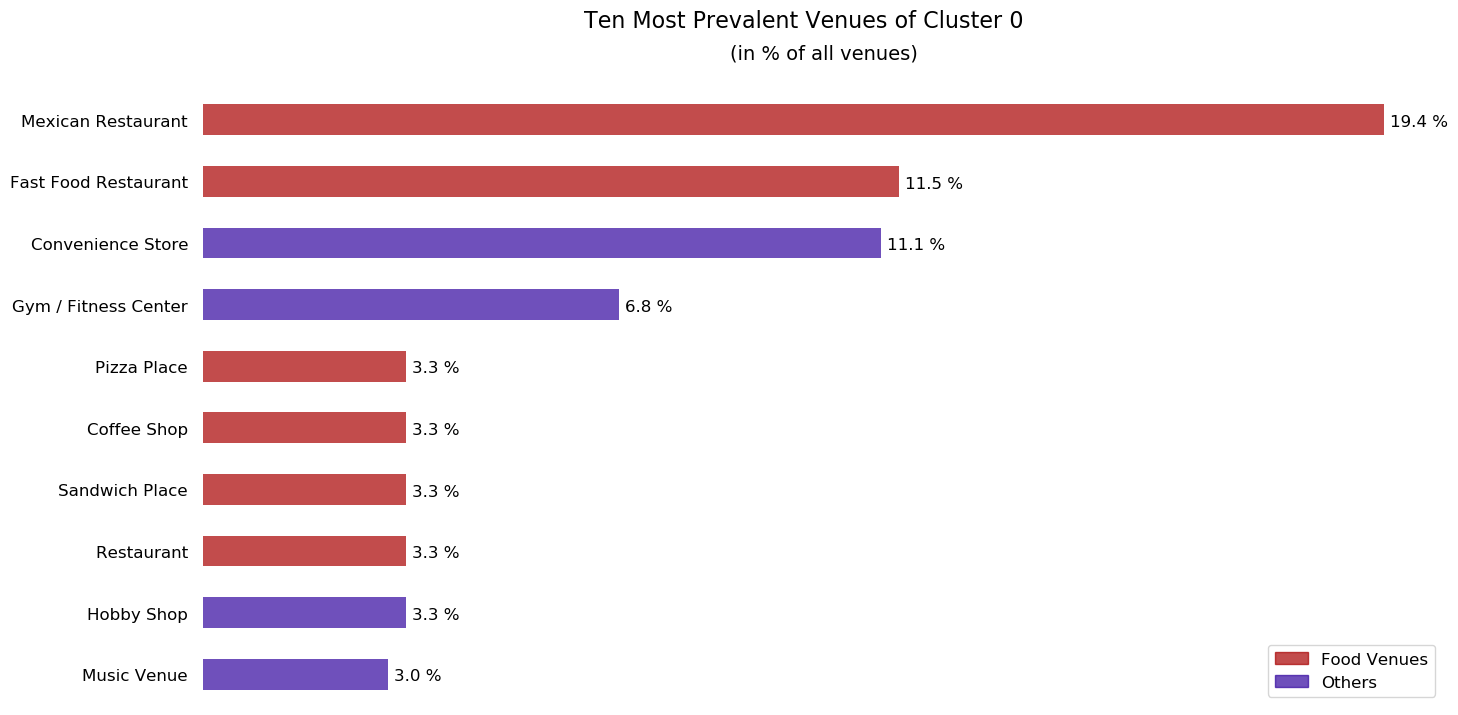

In [1114]:
cluster0=pd.DataFrame(la_results.iloc[0,0:-1]).transpose()
cluster0.sort_values(by='Cluster 0',axis=1,ascending=False,inplace=True)
display(cluster0)

clus0=cluster0.iloc[0,9::-1]
generate_plot(clus0,0)

There are 6 food venues in the top 10 venues of Cluster 0 with Mexican Restaurants making up nearly 20% of all venues. These facts indicate that Cluster 0 would not be the best one to explore further in terms of setting up a new restaurant.


#### *Cluster 1*

,Korean Restaurant,Hotel,Karaoke Bar,Restaurant,Spa,Asian Restaurant,Pool,Speakeasy,Yoga Studio,American Restaurant,Wine Bar,Café,Clothing Store,Coffee Shop,Steakhouse,Mexican Restaurant,Halal Restaurant,Liquor Store,BBQ Joint,Bar,Ice Cream Shop,Seafood Restaurant,Mobile Phone Shop,Bakery,Sandwich Place,Bubble Tea Shop,Salon / Barbershop,New American Restaurant,Food Truck,Juice Bar,Dessert Shop,Gym / Fitness Center,Rental Car Location,Food & Drink Shop,Food,Plaza,Burger Joint,Fast Food Restaurant,Lounge,Japanese Restaurant,Bank,Hotel Bar,Thai Restaurant,Tea Room,Supplement Shop,Shabu-Shabu Restaurant,Pizza Place,Middle Eastern Restaurant,Paper / Office Supplies Store,Library,Martial Arts Dojo,Optical Shop,Other Great Outdoors,Other Repair Shop,Laundry Service,Laundromat,Latin American Restaurant,Kosher Restaurant,Outdoor Sculpture,Women's Store,Marijuana Dispensary,Kitchen Supply Store,Park,Performing Arts Venue,Peruvian Restaurant,Massage Studio,Pet Café,Kids Store,Pet Store,Pharmacy,Opera House,Office,North Indian Restaurant,Noodle House,Miscellaneous Shop,Locksmith,Wings Joint,Men's Store,Photography Studio,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Market,Neighborhood,Mediterranean Restaurant,Lingerie Store,Nightclub,Mattress Store,Light Rail Station,Video Store,Record Shop,Pie Shop,Tapas Restaurant,Spanish Restaurant,Whisky Bar,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tattoo Parlor,Pilates Studio,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train,Train Station,Tree,Tunnel,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Southern / Soul Food Restaurant,South American Restaurant,Soup Place,Soccer Stadium,Playground,Poke Place,Pool Hall,Pub,Public Art,Ramen Restaurant,Video Game Store,Recording Studio,Recreation Center,Wine Shop,Rock Club,Roof Deck,Salad Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Residential Building (Apartment / Condo),ATM,Jewelry Store,Cajun / Creole Restaurant,Chinese Restaurant,Cheese Shop,Cemetery,Caribbean Restaurant,Cantonese Restaurant,Candy Store,Cafeteria,Jazz Club,Butcher,Business Service,Bus Stop,Bus Station,Bus Line,Burrito Place,Church,Circus,Climbing Gym,Cocktail Bar,College Football Field,College Theater,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Building,Buffet,Brewery,Bagel Shop,Adult Boutique,Airport Terminal,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Assisted Living,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,Baby Store,Baseball Field,Breakfast Spot,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Department Store,Design Studio,Dim Sum Restaurant,Historic Site,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym Pool,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,History Museum,Gay Bar,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hunting Supply,Accessories Store,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,General Entertainment,Gastropub,Diner,Filipino Restaurant,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Financial or Legal Service,Gas Station,Fish & Chi

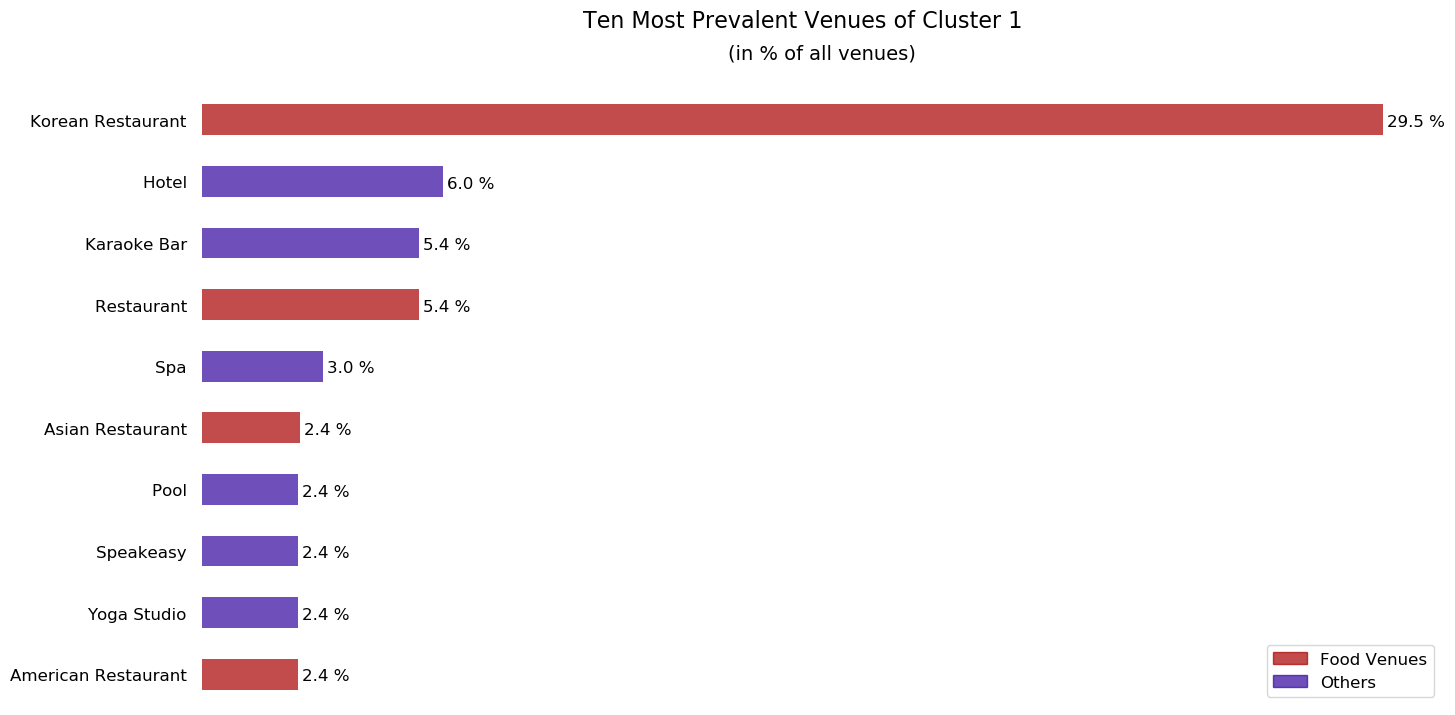

In [1175]:
cluster1=pd.DataFrame(la_results.iloc[1,0:-1]).transpose()
cluster1.sort_values(by='Cluster 1',axis=1,ascending=False,inplace=True)
display(cluster1)

clus1=cluster1.iloc[0,9::-1]
generate_plot(clus1,1)

There are 4 food venues in the top 10 venues of Cluster 1 with Korean Restaurants making up a huge majority (nearly 30%) of all venues. This is unsurprising as Cluster 1 consists of only two neighbourhoods, one being Koreatown and the other (Mid-Wilshire) also having a lot of Korean Restaurants. While there are only 4 food venues in the top 10, the complete dominance of Korean Restaurants in the area indicates the fact that Cluster 1 need not be looked into any further.

#### *Cluster 2*

,Park,Food Truck,Art Museum,Gym,Apartment / Condo,Museum,History Museum,Coffee Shop,Department Store,Science Museum,Sandwich Place,Pool,Gym / Fitness Center,Clothing Store,Intersection,Grocery Store,Restaurant,Other Great Outdoors,Trail,Construction & Landscaping,Other Repair Shop,Hotel,Hotel Bar,Donut Shop,Light Rail Station,Historic Site,Café,Furniture / Home Store,Convenience Store,Cosmetics Shop,Asian Restaurant,Art Gallery,Pizza Place,Nail Salon,Aquarium,Fast Food Restaurant,Food Court,Gift Shop,Exhibit,Sculpture Garden,Bank,Business Service,Office,Plaza,Golf Course,Yoga Studio,Gastropub,Laundry Service,Food Stand,Amphitheater,College Football Field,Football Stadium,Soccer Stadium,Garden,Ice Cream Shop,American Restaurant,Poke Place,Rock Club,Sports Bar,Music Venue,Sporting Goods Shop,Movie Theater,Japanese Restaurant,Taco Place,Hot Dog Joint,Mexican Restaurant,Italian Restaurant,Burger Joint,Bus Station,Jazz Club,Supermarket,Wine Bar,Farmers Market,Bus Stop,Performing Arts Venue,Playground,Breakfast Spot,New American Restaurant,Mobile Phone Shop,Liquor Store,Mediterranean Restaurant,Fried Chicken Joint,French Restaurant,Steakhouse,Concert Hall,Bagel Shop,Tree,Food,Hobby Shop,Home Service,Fish Market,Electronics Store,Candy Store,Dessert Shop,Gym Pool,Assisted Living,Shoe Repair,Wings Joint,Gluten-free Restaurant,Shop & Service,Big Box Store,State / Provincial Park,Moving Target,Moroccan Restaurant,Music Store,Men's Store,Paper / Office Supplies Store,Mattress Store,North Indian Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,Outdoor Sculpture,Miscellaneous Shop,Monument / Landmark,Motel,Neighborhood,Optical Shop,Opera House,Nightclub,Rental Car Location,Pet Café,Southern / Soul Food Restaurant,Spanish Restaurant,Speakeasy,Stadium,Sushi Restaurant,Szechuan Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Train,Udon Restaurant,Vape Store,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Women's Store,Spa,South American Restaurant,Pet Store,Soup Place,Photography Studio,Pie Shop,Pilates Studio,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Market,Roof Deck,Salad Place,Scenic Lookout,School,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Snack Place,Martial Arts Dojo,Indian Restaurant,Deli / Bodega,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,BBQ Joint,College Theater,Comic Shop,Automotive Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Lounge,Design Studio,Auto Garage,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Cemetery,Cajun / Creole Restaurant,English Restaurant,Cafeteria,Basketball Court,Basketball Stadium,Bakery,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Bubble Tea Shop,Buffet,Building,Burrito Place,Bus Line,Butcher,Dumpling Restaurant,Dongbei Restaurant,Baseball Field,Halal Restaurant,Arcade,Health Food Store,Hookah Bar,Airport Terminal,Hostel,Hunting Supply,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Japanese Curry Restaurant,Lingerie Store,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Hardware Store,Hawaiian Restaurant,Garden Center,Athletics & Sports,Fabric Shop,Falafel Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Fountain,Frozen Yogurt Shop,Laundromat,Gas Station,Gay Bar,General Entertainment,Astrologer,Arts & Crafts Store,Locksmith,Library,Tiki Bar,Baby Store,Insurance Office,Adult Boutique,Cantonese Restaurant,Eastern European Restaurant,Train Station,Event Space,Accessories Store,Climbing Gym,Gun Range,High School,Tunnel,Marijuana Dispensary,Supplement Shop,Gourmet

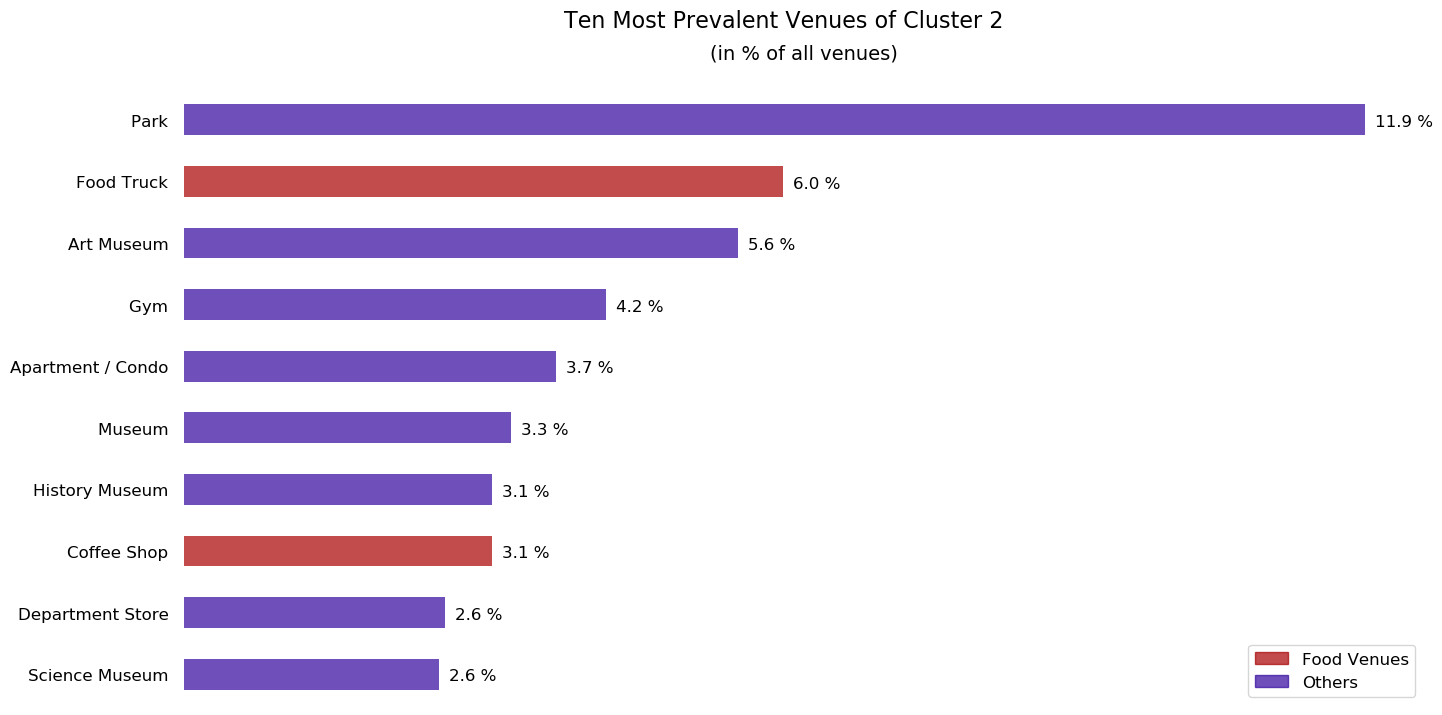

In [1174]:
cluster2=pd.DataFrame(la_results.iloc[2,0:-1]).transpose()
cluster2.sort_values(by='Cluster 2',axis=1,ascending=False,inplace=True)
cluster2.rename(columns={'Residential Building (Apartment / Condo)': 'Apartment / Condo'},inplace=True)
display(cluster2)

clus2=cluster2.iloc[0,9::-1]
generate_plot(clus2,2)

There are only 2 food venues in the top 10 venues of Cluster 2. To add to that, the two venues are Food Trucks and Coffee Shops as opposed to proper restaurants. There are a lot of public venues in this cluster - venues that see a lot of footfall such as parks, museums, gyms and department stores. The presence of condominium complexes in this list also suggest that the population per square unit of these neighbourhoods is high. All of these observations point in the direction of Cluster 2 being nominated as the cluster to explore further.

Having said that, the decision to explore Cluster 2 can only be confirmed after examining Cluster 3: -

#### *Cluster 3*

,Coffee Shop,Mexican Restaurant,Pizza Place,Sandwich Place,Chinese Restaurant,Sushi Restaurant,Grocery Store,Pharmacy,American Restaurant,Fast Food Restaurant,Café,Bar,Convenience Store,Italian Restaurant,Bank,Food Truck,Burger Joint,Gym / Fitness Center,Ice Cream Shop,Thai Restaurant,Bakery,Gym,Japanese Restaurant,Restaurant,Mobile Phone Shop,Park,Art Gallery,Clothing Store,Taco Place,Hotel,Seafood Restaurant,Donut Shop,Deli / Bodega,Cosmetics Shop,Juice Bar,Video Store,Asian Restaurant,Breakfast Spot,Theater,Supermarket,Liquor Store,Shipping Store,Farmers Market,Thrift / Vintage Store,Yoga Studio,Cocktail Bar,Boutique,Spa,Mediterranean Restaurant,Diner,Bookstore,Arts & Crafts Store,Vietnamese Restaurant,Pet Store,Salon / Barbershop,Music Venue,Furniture / Home Store,Indian Restaurant,Fried Chicken Joint,Paper / Office Supplies Store,Middle Eastern Restaurant,New American Restaurant,Shoe Store,French Restaurant,Discount Store,Rental Car Location,Gas Station,Filipino Restaurant,Vegetarian / Vegan Restaurant,Speakeasy,Korean Restaurant,Gastropub,Sports Bar,Athletics & Sports,Bagel Shop,BBQ Joint,ATM,Museum,Gift Shop,Trail,Brewery,Historic Site,Salad Place,Steakhouse,Nail Salon,Latin American Restaurant,Wine Bar,Sporting Goods Shop,Dance Studio,Flower Shop,Intersection,Performing Arts Venue,Department Store,Hot Dog Joint,Health & Beauty Service,Concert Hall,Plaza,Hardware Store,Lounge,Frozen Yogurt Shop,Residential Building (Apartment / Condo),Massage Studio,Automotive Shop,Market,Nightclub,Poke Place,Movie Theater,Music Store,Smoke Shop,Gourmet Shop,Home Service,Skate Park,Electronics Store,Women's Store,Gay Bar,Rock Club,Supplement Shop,Jewelry Store,Fish Market,Bubble Tea Shop,Ramen Restaurant,Noodle House,Cafeteria,Sculpture Garden,Neighborhood,Hawaiian Restaurant,Men's Store,Flea Market,Marijuana Dispensary,Greek Restaurant,Karaoke Bar,Tanning Salon,Indonesian Restaurant,Hookah Bar,Bus Stop,Candy Store,South American Restaurant,Garden Center,Dive Bar,Tunnel,Record Shop,Caribbean Restaurant,Design Studio,Tree,Auto Garage,Food,Airport Terminal,Dessert Shop,Cuban Restaurant,Playground,Dog Run,Other Great Outdoors,Board Shop,Pool,Motel,Southern / Soul Food Restaurant,Martial Arts Dojo,North Indian Restaurant,Business Service,Indie Movie Theater,Bus Station,Shopping Mall,Optical Shop,Jazz Club,Miscellaneous Shop,High School,Pub,Taiwanese Restaurant,Wine Shop,Art Museum,Building,Gym Pool,Assisted Living,Gluten-free Restaurant,Shop & Service,Shopping Plaza,Light Rail Station,Hobby Shop,Brazilian Restaurant,Garden,Arcade,Shoe Repair,State / Provincial Park,Hotel Bar,Climbing Gym,Gun Range,Event Space,Hunting Supply,Kids Store,Beer Store,Lingerie Store,Laundromat,General Entertainment,Japanese Curry Restaurant,Food & Drink Shop,Cajun / Creole Restaurant,Accessories Store,Smoothie Shop,Video Game Store,Tailor Shop,Szechuan Restaurant,Public Art,Dim Sum Restaurant,Financial or Legal Service,Pilates Studio,Recreation Center,Udon Restaurant,History Museum,Wings Joint,Big Box Store,Monument / Landmark,Tea Room,Cantonese Restaurant,Eastern European Restaurant,Bowling Alley,Insurance Office,Baby Store,Beer Garden,Adult Boutique,Toy / Game Store,Scenic Lookout,Cheese Shop,Train Station,Baseball Field,Recording Studio,Opera House,School,Buffet,Snack Place,Circus,Tattoo Parlor,Food Court,Soup Place,Cupcake Shop,Whisky Bar,Irish Pub,Fabric Shop,Kosher Restaurant,Falafel Restaurant,Construction & Landscaping,Pie Shop,Moving Target,Moroccan Restaurant,Tapas Restaurant,Beach,Hostel,Bistro,Photography Studio,Mattress Store,Bike Rental / Bike Share,Comic Shop,Spanish Restaurant,Astrologer,Locksmith,Roof Deck,Cycle Studio,Bus Line,Peruvian Restaurant,Pet Café,Burrito Place,Office,English Restaurant,Dumpling Restaurant,Dongbei Restaurant,Tiki Bar,Stadium,Beer Bar,Outdoor Sculpture,Basketball Stadium,Basketball Court,Butcher,Health Food Store,Church,Fish & Chips Shop,Creperie,Kitchen Supply Store,Fountain,Train,Pool Hall,Vape Store,Cemetery,College Th

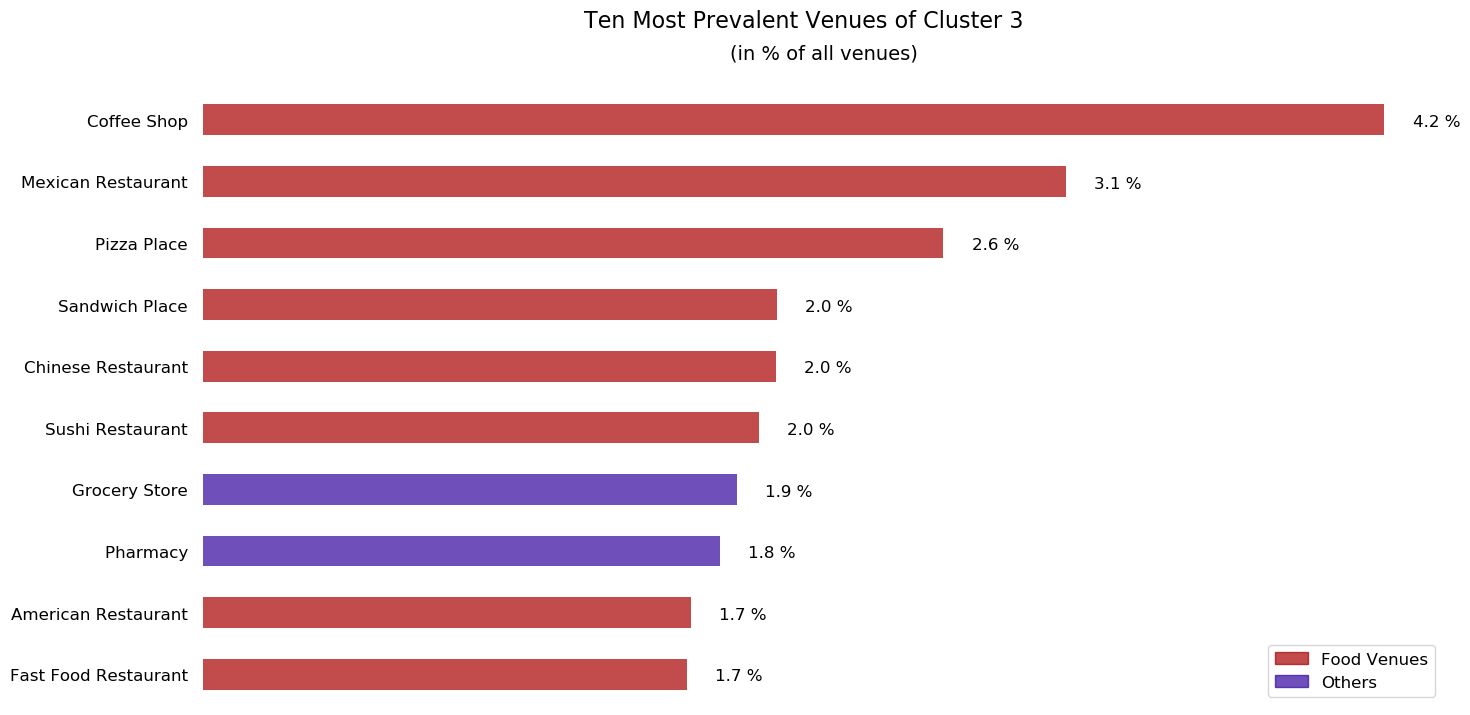

In [1171]:
cluster3=pd.DataFrame(la_results.iloc[3,0:-1]).transpose()
cluster3.sort_values(by='Cluster 3',axis=1,ascending=False,inplace=True)
display(cluster3)

clus3=cluster3.iloc[0,9::-1]
generate_plot(clus3,3)

There are 8 food venues in the top 10 venues of Cluster 3 which is huge percentage. Except for the number 1 venue (Coffee Shops), all other food venues are proper restaurants. This clearly indicates that the neighbourhoods in Cluster 3 are saturated with restaurants already and need not be considered when opening a new restaurant.

It is now safe to confirm the decision of investigating **Cluster 2** further and eliminating all other clusters.

[Back to top of Analysis](#analysis)

### Investigating the chosen Cluster    <a name="investigate"></a>

In [770]:
clus2neigh=la_merged.loc[la_merged['Cluster Label'] == 2, la_merged.columns[0]].values.tolist()
clus2neigh

['Exposition Park',
 'Hancock Park',
 'Montecito Heights',
 'Park La Brea',
 'Playa Vista',
 'Wilshire Center']

In [774]:
filtered_nhoods=nhoods.copy()

for i in range(0,len(filtered_nhoods)):

    if filtered_nhoods.iloc[i,0] not in clus2neigh:
        filtered_nhoods.iloc[i,0]='TO DROP'

In [777]:
filtered_nhoods=filtered_nhoods[filtered_nhoods.Neighbourhood!='TO DROP']
filtered_nhoods.reset_index(drop=True,inplace=True)

The neighbourhoods in Cluster 2 along with their coordinates: -

In [778]:
filtered_nhoods

,Neighbourhood,Latitude,Longitude
0,Exposition Park,34.015651,-118.287180
1,Hancock Park,34.063729,-118.356104
2,Montecito Heights,34.097129,-118.202909
3,Park La Brea,34.067402,-118.355236
4,Playa Vista,33.972790,-118.427578
5,Wilshire Center,34.061515,-118.432771


Function to obtain and display the closest Italian restaurants from each neighbourhood in Cluster 2 and the corresponding distances: -

In [1116]:
def get_neigh_italian(url1):
    
    results = requests.get(url1).json()

    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a data frame
    dataframe = json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    display(dataframe_filtered.loc[:,['name','categories','distance','lat','lng']])

In [851]:
category='4bf58dd8d48988d110941735'#The category for Italian restaurants obtained from https://developer.foursquare.com/docs/resources/categories
radius = 700
LIMIT=30

In [1128]:
for n in range(0,len(filtered_nhoods)):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    filtered_nhoods.iloc[n,1], 
    filtered_nhoods.iloc[n,2], 
    VERSION, 
    category, 
    radius, 
    LIMIT)
    print('------------------------------------------------- '+ filtered_nhoods.iloc[n,0] + ' -------------------------------------------------')
    get_neigh_italian(url)
    print('\n\n')

------------------------------------------------- Exposition Park -------------------------------------------------


,name,categories,distance,lat,lng
0,Cafe 84,Italian Restaurant,545,34.018819,-118.282665





------------------------------------------------- Hancock Park -------------------------------------------------


,name,categories,distance,lat,lng
0,Johnnie's New York Pizza,Pizza Place,217,34.062695,-118.354103
1,Drago Ristorante,Italian Restaurant,498,34.062431,-118.361277
2,Viztango Truck,Food Truck,194,34.062401,-118.354726





------------------------------------------------- Montecito Heights -------------------------------------------------


,name,categories,distance,lat,lng
0,Pasta Fresca Italian Grill,Italian Restaurant,828,34.09276,-118.210181





------------------------------------------------- Park La Brea -------------------------------------------------


,name,categories,distance,lat,lng
0,Miggiano's,Italian Restaurant,488,34.071148,-118.357994
1,La Piazza,Italian Restaurant,560,34.072069,-118.357504
2,Andre's Italian Restaurant & Pizzeria,Italian Restaurant,563,34.070354,-118.360197
3,Johnnie's New York Pizza,Pizza Place,534,34.062695,-118.354103
4,Buca Di Beppo,Italian Restaurant,637,34.071905,-118.359503
5,Viztango Truck,Food Truck,558,34.062401,-118.354726
6,Pappardelle's Pasta,Gourmet Shop,700,34.072133,-118.360240





------------------------------------------------- Playa Vista -------------------------------------------------


,name,categories,distance,lat,lng
0,Ritrovo,Italian Restaurant,452,33.97347,-118.42274





------------------------------------------------- Wilshire Center -------------------------------------------------


,name,categories,distance,lat,lng
0,Carmine's II,Italian Restaurant,837,34.056356,-118.426159
1,Italian Express,Italian Restaurant,913,34.060289,-118.442570


From the data frames above, it can be observed that Park La Brea has 7 Italian Restaurants within 700 meters from its center. Hancock Park has fewer (3) but two of them are less than 250 meters away from its center. This indicates that Park La Brea and Hancock Park would not be suitable neighbourhoods to open an Italian Restaurant and can therefore be eliminated. This leaves the following neighbourhoods: -

In [913]:
filter2_nhoods=filtered_nhoods[(filtered_nhoods.Neighbourhood !='Park La Brea') & (filtered_nhoods.Neighbourhood !='Hancock Park')]
filter2_nhoods.reset_index(drop=True,inplace=True)
filter2_nhoods

,Neighbourhood,Latitude,Longitude
0,Exposition Park,34.015651,-118.287180
1,Montecito Heights,34.097129,-118.202909
2,Playa Vista,33.972790,-118.427578
3,Wilshire Center,34.061515,-118.432771


Computing the distance of each neighbourhood from the center of LA and adding it as a column to the existing data frame: -

In [914]:
filter2_nhoods = filter2_nhoods.reindex( columns = filter2_nhoods.columns.tolist() + ['Distance from LA center (in km)'])  #this way to avoid warnings

In [915]:
from math import radians, sin, cos, acos

slat = radians(34.0536909) #LA center Latitude obtained earlier
slon = radians(-118.2427666) #LA center Longitude obtained earlier

In [916]:
for n in range(0,len(filter2_nhoods)):
    
    elat = radians(filter2_nhoods.iloc[n,1])
    elon = radians(filter2_nhoods.iloc[n,2])

    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    filter2_nhoods.loc[n,'Distance from LA center (in km)']=dist

In [923]:
filter2_nhoods.sort_values(by='Distance from LA center (in km)',inplace=True)
filter2_nhoods.reset_index(drop=True,inplace=True)
filter2_nhoods

,Neighbourhood,Latitude,Longitude,Distance from LA center (in km)
0,Exposition Park,34.015651,-118.287180,5.885687
1,Montecito Heights,34.097129,-118.202909,6.066799
2,Wilshire Center,34.061515,-118.432771,17.525272
3,Playa Vista,33.972790,-118.427578,19.263591


It is clear from the data frame above that **Exposition Park** (~6km) and **Montecito Heights** (~6km) are much closer to the center of Los Angeles than Wilshire Center (~17.5km) and Playa Vista (~19km). Since the distance from LA center is a criterion in choosing the optimal neighbourhood, Wilshire Center and Playa Vista would not be appropriate choices.

[Back to top of Analysis](#analysis)

### Web Scraping Rent Data  <a name="rent"></a>

The list of average rent of all neighbourhoods in LA can be obtained by scraping the relevant webpage. The data in the webpage is in the form of a table. Therefore, the data can be obtained much more easily.

In [924]:
url = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/').text
soup = BeautifulSoup(url,"html.parser")

In [944]:
table = soup.find('table',id="MarketTrendsAverageRentTable")
pr = table.find_all('td')
nh = table.find_all('th')

In [951]:
price = []
neighbourhood = []

for i in range(0, len(pr)):
    price.append(pr[i].text.strip())
    neighbourhood.append(nh[i+2].text.strip())
        
df_rent = pd.DataFrame(data=[neighbourhood, price]).transpose()
df_rent.columns = ['Neighbourhood', nh[1].text]
df_rent.loc[32,'Neighbourhood']='Montecito Heights' #Correcting a spelling error
df_rent

,Neighbourhood,Average Rent
0,Jefferson Park,"$1,226"
1,Vermont Vista,"$1,408"
2,Vermont Knolls,"$1,408"
3,El Sereno,"$1,438"
4,Glassell Park,"$1,441"
5,Cypress Park,"$1,441"
6,Winnetka,"$1,480"
7,Leimert Park,"$1,501"
8,Arlington Heights,"$1,544"
9,North Hills,"$1,544"


The above data frame is already in ascending order of average rent. The 2 neighbourhoods in question can be identified from the table and their average rents displayed: -

In [957]:
df_rent[(df_rent['Neighbourhood']=='Exposition Park') | (df_rent['Neighbourhood']=='Montecito Heights')]

,Neighbourhood,Average Rent
32,Montecito Heights,"$1,761"
107,Exposition Park,"$3,438"


The average rent in Exposition Park is nearly two times the average rent in Montecito Heights. This means that Exposition Park is a significantly more expensive neighbourhood. 

[Back to top of Analysis](#analysis)

## <u>Results and Discussion</u><a name="results"></a>

<p style='text-align: justify;'>In the beginning of the analysis the data frame of Los Angeles neighbourhoods was trimmed to include only the ones that had 10 or more venues. This decision was taken as it made sense to set up a restaurant in one of the more popular neighbourhoods, thereby attracting the attention of a lot more people.</p>

<p style='text-align: justify;'>When clustering the neighbourhoods, the optimal value of k (k=4) for the dataset was arrived at using the Silhouette Coefficient Method. As a consequence, all neighbourhoods were grouped into 4 clusters using k-means clustering. In order to examine the deterministic characteristics of each cluster, a data frame for each cluster was created that included their most frequently occurring venues in descending order. A horizontal bar plot was generated showing the top 10 venues for each cluster, highlighting the food venues. This helped in determining the optimal cluster for further analysis. All of the observations pointed in the direction of Cluster 2 being that cluster. It had only 2 food venues amongst the top 10 - food trucks and coffee shops - which were not full-fledged restaurants. The cluster also had apartment complexes and a lot of public venues which meant that the neighbourhoods in it see a lot of people.</p>

<p style='text-align: justify;'>The following step was to obtain and display the closest Italian restaurants from each neighbourhood in Cluster 2 and their corresponding distances. It was observed that Park La Brea has 7 Italian Restaurants within 700 meters from its center. Hancock Park had fewer (3) but two of them were less than 250 meters away from its center. This indicated that Park La Brea and Hancock Park would not be suitable neighbourhoods to open an Italian Restaurant in and were eliminated. </p>

<p style='text-align: justify;'>The next criteria was the distance of each of the remaining neighbourhoods from the center of the city. It was found that Exposition Park (~6km) and Montecito Heights (~6km) are much closer to the center of Los Angeles than Wilshire Center (~17.5km) and Playa Vista (~19km). Therefore, it was understood that Wilshire Center and Playa Vista would not be appropriate choices.</p>

<p style='text-align: justify;'>The table of average rent of all neighbourhoods in LA was obtained by scraping the relevant webpage. The two neighbourhoods that remained in contention were identified from the table and their average rents displayed. It was detected that the average rent in Exposition Park is nearly two times the average rent in Montecito Heights, implying that Exposition Park is a significantly more expensive neighbourhood. However, this does not automatically mean Montecito Heights is the better option. A factor to consider is the type of restaurant the shareholder is interested in setting up. If, for example, a high-end fine dining restaurant needs to be set up, a neighbourhood that has a low average rent would not work. The reason for this is that such a neighbourhood would generally be home to people with lower income and a high-end fine dining restaurant may not see a healthy influx of people. On the other hand, if a fast-casual/casual dining restaurant needs to be set up, a high-rent neighbourhood would not be ideal simply because the restaurant will not be able to afford the rented space. While average rent can point in the direction of the right neighbourhood, a final decision cannot be made without all the required information. </p>

[Back to top of notebook](#top)

## <u>Conclusion</u><a name="conclusion"></a>

<div style="text-align: justify"> The objective of this project was to identify the best potential neighbourhoods in Los Angeles where an Italian restaurant can be set up. All the required neighbourhood data was either scraped of the internet or obtained using a geolocator. After the neighbourhoods were visualized on a folium map, their venues were explored using Foursquare location data. Based on the frequency of occurrences of different venue types, the neighbourhoods were divided into four groups with the help of k-means clustering. The clusters were examined and the best one in which a restaurant could be set up was chosen. The neighbourhoods were filtered further based on proximity to existing Italian restaurants and distance from the center of the city. The analysis brought the number of contenders down to two neighbourhoods - **Exposition Park** and **Montecito Heights**. Average neighbourhood rent data was called upon and while it provided interesting insights, it could not influence the decision only with the information at hand. As touched upon earlier, the results of the analysis highlight potential neighbourhoods where an Italian restaurant may be opened solely based on geographical location and proximity to competitors. This will only serve as a starting point in the overall investigation since there are a lot of other factors - availability of commercial spaces, appeal of each location, proximity to major roads, access through public transport, etc. - that influence such a decision. </div>

[Back to top of notebook](#top)